## Задача 10. Классификация на выбранном датасете.

In [ ]:
!pip install opendatasets

Импорт модулей

In [ ]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Подготовка данных

Возьмем датасет wine-reviews с kaggle

В датасете содержится информация о винах. Информации по столбцам соответсвуют списку ниже.

* Страна-производитель;
* описание;
* виноградник на территории винодельни, откуда собирают виноград;
* оценка вина; цена за бутылку;
* провинция или штат, из которого произведено вино;
* винодельческий район в провинции или штате;
* иногда в пределах винодельческого региона указываются более конкретные регионы;
* имя дегустатора;
* твитер аккаунт дегустатора;
* название;
* сорт винограда;
* винодельня.

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/zynicide/wine-reviews")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Shcherbakov
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/zynicide/wine-reviews


100%|██████████| 50.9M/50.9M [00:00<00:00, 86.9MB/s]


In [ ]:
wine_reviews = pd.read_csv("wine-reviews/winemag-data-130k-v2.csv", index_col='Unnamed: 0')
wine_reviews

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


Так как датасет довольно большой выберем одну страну для рассмотрения.

In [ ]:
wine_reviews.groupby("country")['title'].count()

,title
country,
Argentina,3800
Armenia,2
Australia,2329
Austria,3345
Bosnia and Herzegovina,2
Brazil,52
Bulgaria,141
Canada,257
Chile,4472


Наибольшее количество информации содержится о винах Америки, Франции и Италии.

Рассмотрим Италию.

In [ ]:
wine_reviews = wine_reviews[wine_reviews['country'] == 'Italy']

Добавим год разлива вина. Пропущенные значения заменим медианой для сорта.

In [ ]:
def unwrap_list(num_in_list):
  try:
    return num_in_list[0]
  except:
    return np.nan

In [ ]:
wine_reviews['year'] = wine_reviews['title'].transform(lambda x: unwrap_list(list(filter(lambda a: a.isdigit() and len(a) == 4, x.split())))).astype(float)
wine_reviews['year'] = wine_reviews.groupby(['variety'])['year'].transform(lambda x: x.fillna(x.median()))
wine_reviews

<ipython-input-8-33f690768e06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_reviews['year'] = wine_reviews['title'].transform(lambda x: unwrap_list(list(filter(lambda a: a.isdigit() and len(a) == 4, x.split())))).astype(float)
<ipython-input-8-33f690768e06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine_reviews['year'] = wine_reviews.groupby(['variety'])['year'].transform(lambda x: x.fillna(x.median()))


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013.0
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo,2013.0
13,Italy,This is dominated by oak and oak-driven aromas...,Rosso,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Masseria Setteporte 2012 Rosso (Etna),Nerello Mascalese,Masseria Setteporte,2012.0
22,Italy,Delicate aromas recall white flower and citrus...,Ficiligno,87,19.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Baglio di Pianetto 2007 Ficiligno White (Sicilia),White Blend,Baglio di Pianetto,2007.0
24,Italy,"Aromas of prune, blackcurrant, toast and oak c...",Aynat,87,35.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Canicattì 2009 Aynat Nero d'Avola (Sicilia),Nero d'Avola,Canicattì,2009.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129929,Italy,"This luminous sparkler has a sweet, fruit-forw...",NaN,91,38.0,Veneto,Prosecco Superiore di Cartizze,NaN,NaN,NaN,Col Vetoraz Spumanti NV Prosecco Superiore di...,Prosecco,Col Vetoraz Spumanti,2007.0
129943,Italy,"A blend of Nero d'Avola and Syrah, this convey...",Adènzia,90,29.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,Baglio del Cristo di Campobello 2012 Adènzia R...,Red Blend,Baglio del Cristo di Campobello,2012.0
129947,Italy,"A blend of 65% Cabernet Sauvignon, 30% Merlot ...",Symposio,90,20.0,Sicily & Sardinia,Terre Siciliane,NaN,Kerin O’Keefe,@kerinokeefe,Feudo Principi di Butera 2012 Symposio Red (Te...,Red Blend,Feudo Principi di Butera,2012.0
129961,Italy,"Intense aromas of wild cherry, baking spice, t...",NaN,90,30.0,Sicily & Sardinia,Sicilia,NaN,Kerin O’Keefe,@kerinokeefe,COS 2013 Frappato (Sicilia),Frappato,COS,2013.0


Посмотрим есть ли в region_2 не NaN значения.

In [ ]:
wine_reviews['region_2'].notnull().sum()

0

Нет.

Посмотрим на количество вин, оцененных каждым дегустатором.

In [ ]:
wine_reviews['taster_name'].value_counts()

,count
taster_name,
Kerin O’Keefe,10776
Roger Voss,97
Joe Czerwinski,89
Michael Schachner,76
Paul Gregutt,4


При таком распределении Kerin O’Keefe почти не будет влиять на обучение, а остальные признаки могут влиять слишком сильно или не попасть в тренировочную выборку. Уберем этот признак.

Будем пытаться предсказать сорт вина

Заметим, что некоторые сорта встречаются всего несколько раз, поэтому они могут, либо не попасть в тренировочную выборку, либо слишком сильно влиять на модель.

Страна у всех вин одна. Убираем столбец country.

Так как description яляется уникальным признаком, то оно не повлияет на обучение.

Информации о винограднике на территории винодельни не содержательна т.к. винодельня может содержать несколько виноградников. Оба признака могут замедлить модель, т.к. они связаны, то оставим один. Если оставить информацию о винограднике вместо винодельни, то шанс переобучения выше. Убираем столбец designation.

По аналогичной причине оставляем province и убираем region_1.

В region_2 все значения NaN. Убираем.

Хранить информацию о твитере дегустатора, очевидно, не нужно.

Так как title яляется уникальным признаком, то оно не повлияет на обучение.


Удалим эти данные.


In [ ]:
match_id_counts = wine_reviews['variety'].value_counts()
match_id_counts[:10]

,count
variety,
Red Blend,3624
Nebbiolo,2736
Sangiovese,2265
White Blend,779
Sangiovese Grosso,750
Glera,709
"Corvina, Rondinella, Molinara",619
Pinot Grigio,605
Barbera,479


Оставим первые три сорта вина, т.к. между ними разница в количестве строк не так велика, как между 3 и 4 (нумеруя с 1 сверху).

In [ ]:
valid_match_ids = match_id_counts[match_id_counts >= 2265].index
data = pd.DataFrame(wine_reviews[wine_reviews['variety'].isin(valid_match_ids)][['points', 'price', 'province', 'winery', 'year', 'variety']])
data['province'] = data['province'].replace({'Sicily & Sardinia' : 'Sicily and Sardinia'})
data

,points,price,province,winery,year,variety
28,87,17.0,Sicily and Sardinia,Terre di Giurfo,2011.0,Red Blend
31,86,NaN,Sicily and Sardinia,Duca di Salaparuta,2010.0,Red Blend
50,86,NaN,Sicily and Sardinia,Viticultori Associati Canicatti,2008.0,Red Blend
54,85,NaN,Sicily and Sardinia,Corvo,2010.0,Red Blend
61,86,17.0,Central Italy,Podere dal Nespoli,2015.0,Sangiovese
...,...,...,...,...,...,...
129826,88,50.0,Piedmont,Vinchio-Vaglio Serra,2006.0,Nebbiolo
129844,86,NaN,Tuscany,Caparzo,2006.0,Sangiovese
129892,91,72.0,Tuscany,La Mannella,2012.0,Sangiovese
129943,90,29.0,Sicily and Sardinia,Baglio del Cristo di Campobello,2012.0,Red Blend


In [ ]:
data['points'] = data['points'].astype(int)
data['price'] = data['price'].astype(float)
data['province'] = data['province'].astype('category')
data['winery'] = data['winery'].astype('category')
data['variety'] = data['variety'].astype('category')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8625 entries, 28 to 129947
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   points    8625 non-null   int64   
 1   price     7468 non-null   float64 
 2   province  8625 non-null   category
 3   winery    8625 non-null   category
 4   year      8625 non-null   float64 
 5   variety   8625 non-null   category
dtypes: category(3), float64(2), int64(1)
memory usage: 381.7 KB


Заменим NaN значения цены на средние по провинции.

In [ ]:
data['price'] = data.groupby(['province'])['price'].transform(lambda x: x.fillna(x.mean()))
data.isnull().sum()

<ipython-input-39-e9db7da44e0d>:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,0
points,0
price,0
province,0
winery,0
year,0
variety,0


 # Визуализация

Посмотрим на зависимость сорта винограда в зависимости от провинции

In [ ]:
fig = px.scatter(data, x='province', y='variety', title="Scatter plot: variety by province")
fig.show()

Можно заметить, что в каждой провинции используются не все сорта. Значит признак будет влиять на модель.

Посмотрим на количество строк для каждого сорта.

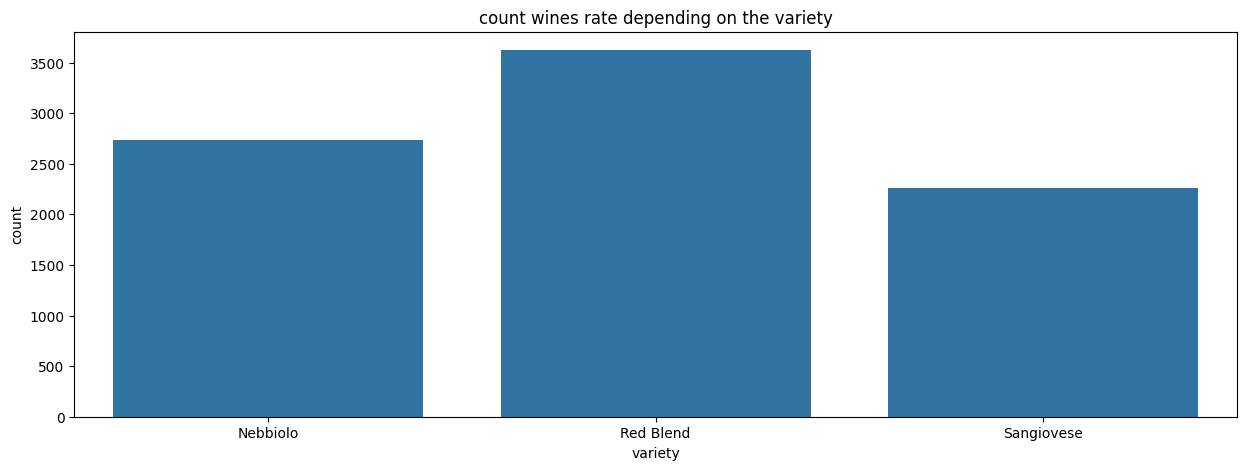

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data=data, x='variety')
plt.title("count wines rate depending on the variety")
plt.xlabel("variety")
plt.ylabel("count")
plt.show()

Заметим, что разница между столбцами не очень большая, значит, скорее всего, точность предсказаний будет не сильно отличться.

Посмотрим на количество в зависимости от оценки

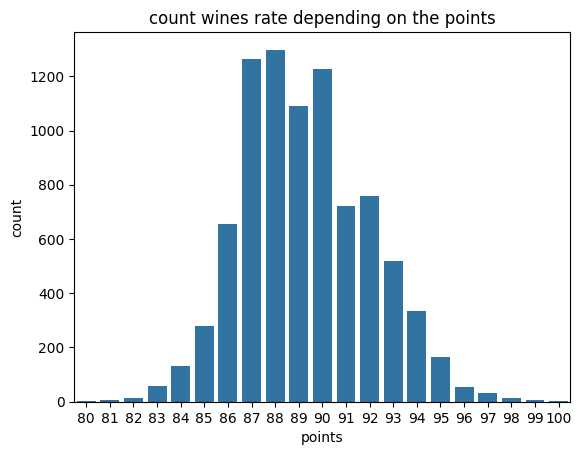

In [ ]:
sns.countplot(data=data, x='points')
plt.title("count wines rate depending on the points")
plt.xlabel("points")
plt.ylabel("count")
plt.show()

Видим, что количество вин с оценкой в диапазоне 87-90 больше всего, следовательно, для них признак оценки будет меньше влиять на модель.

Проверим что оценка и стоимость вина не линейно-зависимы.

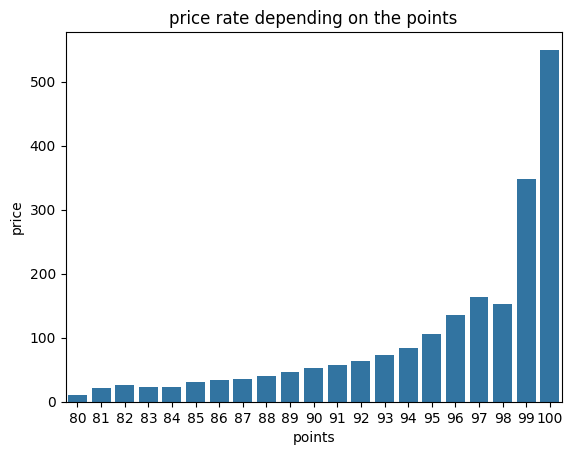

In [ ]:
sns.barplot(data=data, x='points', y='price', errorbar=None)
plt.title("price rate depending on the points")
plt.xlabel("points")
plt.ylabel("price")
plt.show()

Проверили. Признаки не линейно-зависимы.

Посмотрим на зависимость оценки вина от года розлива.

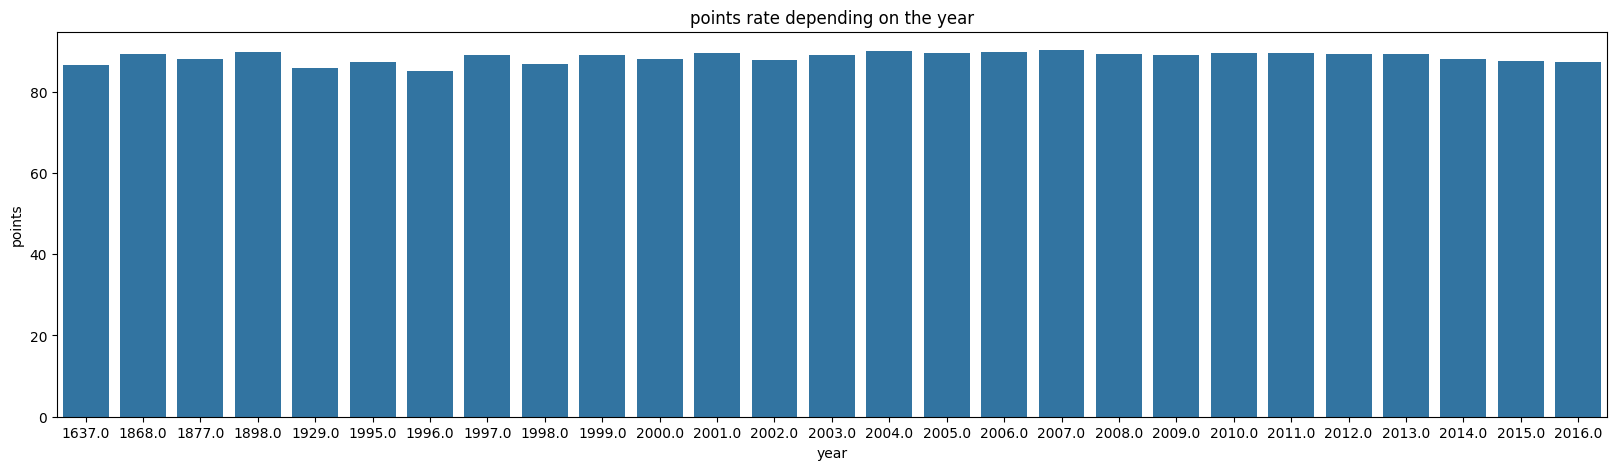

In [ ]:
plt.figure(figsize=(20, 5))
sns.barplot(data=data, x='year', y='points', errorbar=None)
plt.title("points rate depending on the year")
plt.xlabel("year")
plt.ylabel("points")
plt.show()

Проверили. Значения не линейно-зависимы. Функцию нельзя считать константной т.к. колебания оценки на 1-2 могут быть существенны (видно из предыдущего графика).

Посмотрим на зависимость цены вина от года розлива.

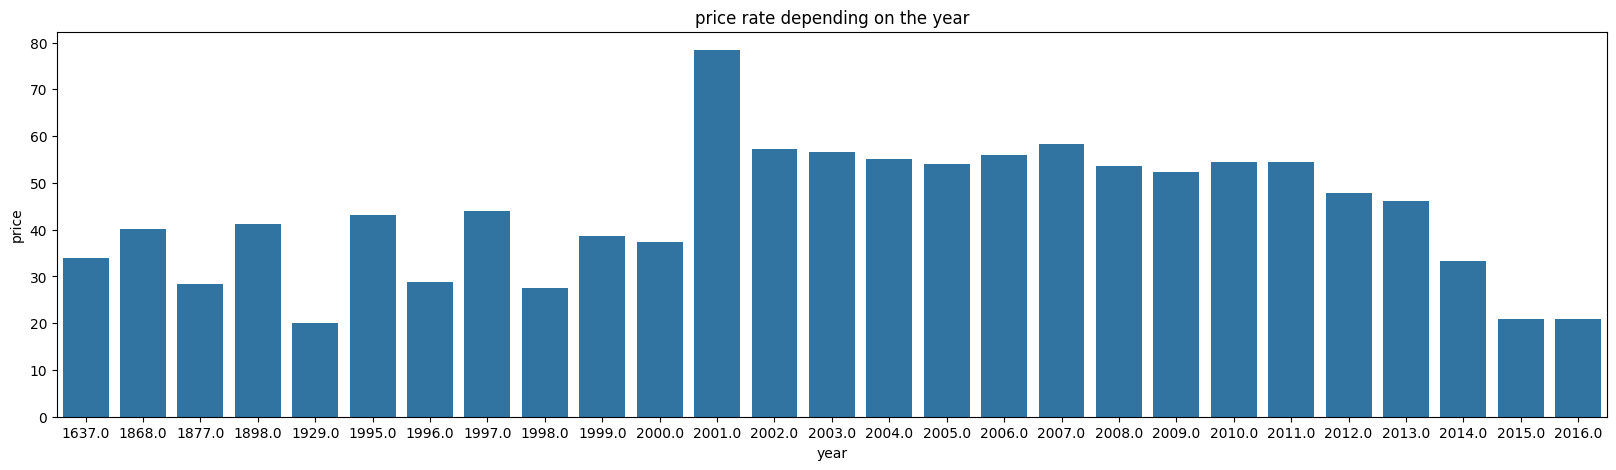

In [250]:
plt.figure(figsize=(20, 5))
sns.barplot(data=data, x='year', y='price', errorbar=None)
plt.title("price rate depending on the year")
plt.xlabel("year")
plt.ylabel("price")
plt.show()

Проверили. Признаки не линейно-зависимы.

# Модель и обучение

In [181]:
X = data.drop(['variety'], axis=1)
Y = data['variety']

Представляем данные в виде необходимом для обучения.

In [182]:
province = pd.get_dummies(X['province'], drop_first=True)
winery = pd.get_dummies(X['winery'], drop_first=True)

X_gd = X.drop(['province', 'winery'], axis=1)

X_gd = pd.concat([X_gd, province, winery], axis=1)

Разбиваем данные на тренировочные и тестовые

In [183]:
X_train_gd, X_test_gd, Y_train, Y_test = train_test_split(X_gd, Y, test_size=0.2, random_state=42)
X_train_gd

,points,price,year,Italy Other,Lombardy,Northeastern Italy,Northwestern Italy,Piedmont,Sicily and Sardinia,Southern Italy,...,Vèscine,Wine for Food,Zanoni,Zenato,Zeni,Ziobaffa,Zisola,Zonin,Zymè,Ïl Macchione
47486,91,55.000000,2007.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
122282,87,44.428758,2011.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
96663,87,20.000000,2011.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21437,88,26.000000,2013.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
66082,87,45.000000,2013.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84833,86,45.000000,2013.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
77114,87,44.428758,2006.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
80524,88,23.000000,2015.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12797,88,18.000000,2013.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Сперва попробуем модель с прошлого дз с подбором параметров.

In [184]:
from sklearn.tree import DecisionTreeClassifier

# create dict with paramemeters for model
param_grid_clf = {
    'criterion': ('entropy', 'gini', 'log_loss'),
    'max_depth': [5, 10, None],
}

# create model
clf = DecisionTreeClassifier(random_state=42)

# selection of best parameters
grid_search_clf = GridSearchCV(clf, param_grid_clf, n_jobs=-1, scoring='accuracy')

# train model
grid_search_clf.fit(X_train_gd, Y_train)

# check of best parameters
print("best parameters for DecisionTreeClassifier:", grid_search_clf.best_params_)

# prediction of results
y_pred_dtc_gd = grid_search_clf.predict(X_test_gd)

# check of metric values
print(classification_report(Y_test, y_pred_dtc_gd))

best parameters for DecisionTreeClassifier: {'criterion': 'gini', 'max_depth': None}
              precision    recall  f1-score   support

    Nebbiolo       0.99      0.98      0.98       526
   Red Blend       0.82      0.87      0.84       742
  Sangiovese       0.78      0.71      0.75       457

    accuracy                           0.86      1725
   macro avg       0.86      0.85      0.86      1725
weighted avg       0.86      0.86      0.86      1725



Видим, что модель неплохо справляется с предсказанием.

Представим данные в другом виде т.к. для других моделей обучение на таких данных происходит очень долго.

In [185]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# LabelEncoder

In [186]:
lbe = LabelEncoder()
X_lbe = pd.DataFrame(X)
X_lbe['province'] = lbe.fit_transform(data['province'])
X_lbe['winery'] = lbe.fit_transform(data['winery'])
X_train_lbe, X_test_lbe, Y_train, Y_test = train_test_split(X_lbe, Y, test_size=0.2, random_state=42)
X_train_lbe

,points,price,province,winery,year
47486,91,55.000000,5,1005,2007.0
122282,87,44.428758,8,1670,2011.0
96663,87,20.000000,9,35,2011.0
21437,88,26.000000,8,884,2013.0
66082,87,45.000000,5,1005,2013.0
...,...,...,...,...,...
84833,86,45.000000,5,137,2013.0
77114,87,44.428758,8,127,2006.0
80524,88,23.000000,8,777,2015.0
12797,88,18.000000,8,1248,2013.0


In [187]:
param_grid_clf = {
    'criterion': ('entropy', 'gini', 'log_loss'),
    'max_depth': [5, 10, None],
}
clf = DecisionTreeClassifier(random_state=42)
grid_search_clf = GridSearchCV(clf, param_grid_clf, n_jobs=-1, scoring='accuracy')
grid_search_clf.fit(X_train_lbe, Y_train)
y_pred_dtc_lbe = grid_search_clf.predict(X_test_lbe)

print("best parameters for DecisionTreeClassifier:", grid_search_clf.best_params_)
print(classification_report(Y_test, y_pred_dtc_lbe))

best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None}
              precision    recall  f1-score   support

    Nebbiolo       0.99      0.98      0.99       526
   Red Blend       0.80      0.80      0.80       742
  Sangiovese       0.69      0.70      0.70       457

    accuracy                           0.83      1725
   macro avg       0.83      0.83      0.83      1725
weighted avg       0.83      0.83      0.83      1725



Видим незначительное падение точночности модели.

Попробуем другие модели

In [188]:
from sklearn.linear_model import SGDClassifier

# create dict with paramemeters for model
param_grid_clf = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_error'],
    'max_iter': [100, 200, 400, 800, 1000]
}

# create model
clf = SGDClassifier(random_state=42)

# selection of best parameters
grid_search_clf = GridSearchCV(clf, param_grid_clf, n_jobs=-1, scoring='accuracy')

# train model
grid_search_clf.fit(X_train_lbe, Y_train)

# check of best parameters
print("best parameters for SGDClassifier:", grid_search_clf.best_params_)

# prediction of results
y_pred_sgdc_lbe = grid_search_clf.predict(X_test_lbe)

# check of metric values
print(classification_report(Y_test, y_pred_sgdc_lbe))

best parameters for SGDClassifier: {'loss': 'modified_huber', 'max_iter': 200}
              precision    recall  f1-score   support

    Nebbiolo       0.30      1.00      0.47       526
   Red Blend       0.00      0.00      0.00       742
  Sangiovese       0.00      0.00      0.00       457

    accuracy                           0.30      1725
   macro avg       0.10      0.33      0.16      1725
weighted avg       0.09      0.30      0.14      1725



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Точность модели SGDClassifier очень низкая.

Были попытки перебирать разные параметры ядра модли SVC, но это катастрафически замедляло процесс, а результаты не становились сильно лучше, поэтому тут использую дефолтные параметры.

In [189]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train_lbe, Y_train)
y_pred_svc_lbe = clf.predict(X_test_lbe)

# check of metric values
print(classification_report(Y_test, y_pred_svc_lbe))

              precision    recall  f1-score   support

    Nebbiolo       0.52      0.22      0.31       526
   Red Blend       0.46      0.93      0.61       742
  Sangiovese       0.00      0.00      0.00       457

    accuracy                           0.46      1725
   macro avg       0.33      0.38      0.31      1725
weighted avg       0.36      0.46      0.36      1725



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Точность у модели SVC очень низкая.

# PCA

In [190]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_gd)
X_test_pca = pca.transform(X_test_gd)
X_train_pca

array([[ 4.26507051e+00, -2.31516787e+00,  1.63172872e+00, ...,
         3.58225259e-18,  2.88184583e-18,  1.30234266e-20],
       [-6.43751638e+00,  1.66052025e+00, -2.08758127e+00, ...,
         3.15901817e-18,  1.87872264e-19, -8.05538076e-20],
       [-3.08530170e+01,  1.59344524e+00, -1.33581991e+00, ...,
        -2.35725523e-18, -1.67147617e-18,  1.11176722e-20],
       ...,
       [-2.78372126e+01,  5.59889241e+00, -4.34360135e-01, ...,
        -5.38174105e-20, -7.44436577e-21,  8.56165509e-21],
       [-3.28294277e+01,  3.58499107e+00, -2.86877737e-01, ...,
        -4.94705731e-20, -2.86098011e-20,  3.72404376e-21],
       [-3.48845942e+01,  2.58382951e+00, -2.20524267e+00, ...,
        -6.24065254e-20, -3.38691686e-20,  1.20095839e-21]])

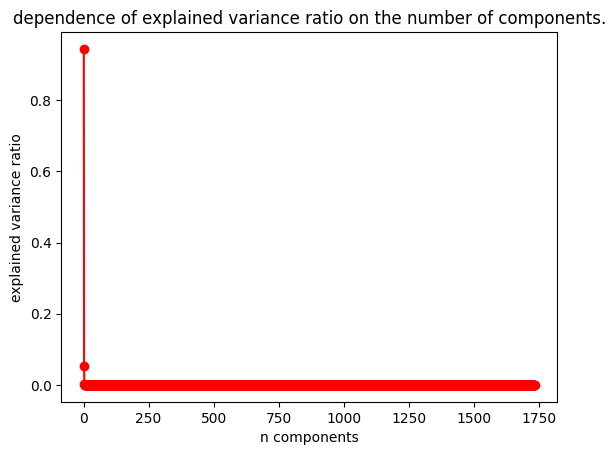

In [191]:
plt.plot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_, 'ro-')
plt.title('dependence of explained variance ratio on the number of components.')
plt.xlabel('n components')
plt.ylabel('explained variance ratio')
plt.show()

Видим что большинство параметров дает распределение дисперсии близкое к нулю. Но их количество все ещё слишком велико.

Попробуем установить конкретное количество компонент.

In [192]:
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_gd)
X_test_pca = pca.transform(X_test_gd)
X_train_pca

array([[ 4.26507051e+00, -2.31516787e+00,  1.63172872e+00, ...,
         5.05657142e-04,  3.32621442e-03,  6.09493572e-03],
       [-6.43751638e+00,  1.66052025e+00, -2.08758127e+00, ...,
        -3.35528178e-03,  1.48453024e-03,  1.42042476e-03],
       [-3.08530170e+01,  1.59344524e+00, -1.33581991e+00, ...,
         1.46636958e-03,  3.41066691e-03, -1.85772109e-03],
       ...,
       [-2.78372126e+01,  5.59889241e+00, -4.34360135e-01, ...,
        -5.51559775e-03,  1.44925595e-03,  6.24520492e-03],
       [-3.28294277e+01,  3.58499107e+00, -2.86877737e-01, ...,
        -5.74142636e-03,  1.06299879e-03,  2.40827452e-03],
       [-3.48845942e+01,  2.58382951e+00, -2.20524267e+00, ...,
         1.57198953e-02,  1.40492514e-02,  1.21808361e-02]])

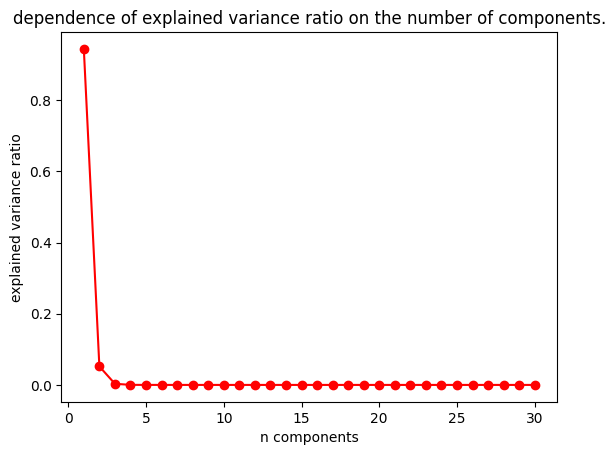

In [193]:
plt.plot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_, 'ro-')
plt.title('dependence of explained variance ratio on the number of components.')
plt.xlabel('n components')
plt.ylabel('explained variance ratio')
plt.show()

In [194]:
param_grid_clf = {
    'criterion': ('entropy', 'gini', 'log_loss'),
    'max_depth': [5, 10, None],
}
clf = DecisionTreeClassifier(random_state=42)
grid_search_clf = GridSearchCV(clf, param_grid_clf, n_jobs=-1, scoring='accuracy')
grid_search_clf.fit(X_train_pca, Y_train)
y_pred_dtc_pca = grid_search_clf.predict(X_test_pca)

print("best parameters for DecisionTreeClassifier:", grid_search_clf.best_params_)
print(classification_report(Y_test, y_pred_dtc_pca))

best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None}
              precision    recall  f1-score   support

    Nebbiolo       0.98      0.98      0.98       526
   Red Blend       0.76      0.74      0.75       742
  Sangiovese       0.62      0.64      0.63       457

    accuracy                           0.79      1725
   macro avg       0.78      0.79      0.78      1725
weighted avg       0.79      0.79      0.79      1725



Видим, что после уменьшения размерности с помощью PCA модель неплохо справляется с предсказанием.

In [195]:
param_grid_clf = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_error'],
    'max_iter': [100, 200, 400, 800, 1000]
}
clf = SGDClassifier(random_state=42)
grid_search_clf = GridSearchCV(clf, param_grid_clf, n_jobs=-1, scoring='accuracy')
grid_search_clf.fit(X_train_pca, Y_train)
y_pred_sgdc_pca = grid_search_clf.predict(X_test_pca)


print("best parameters for SGDClassifier:", grid_search_clf.best_params_)
print(classification_report(Y_test, y_pred_sgdc_pca))

best parameters for SGDClassifier: {'loss': 'hinge', 'max_iter': 100}
              precision    recall  f1-score   support

    Nebbiolo       0.97      0.98      0.97       526
   Red Blend       0.67      0.83      0.74       742
  Sangiovese       0.59      0.35      0.44       457

    accuracy                           0.75      1725
   macro avg       0.74      0.72      0.72      1725
weighted avg       0.74      0.75      0.73      1725



Такая модель так же неплохо справляется с предсказанием, но все же менее точно чем DecisionTreeClassifier.

In [196]:
clf = SVC()
clf.fit(X_train_pca, Y_train)
y_pred_svc_pca = clf.predict(X_test_pca)

print(classification_report(Y_test, y_pred_svc_pca))

              precision    recall  f1-score   support

    Nebbiolo       0.85      0.93      0.88       526
   Red Blend       0.62      0.86      0.72       742
  Sangiovese       0.67      0.18      0.28       457

    accuracy                           0.70      1725
   macro avg       0.71      0.65      0.63      1725
weighted avg       0.70      0.70      0.65      1725



Такая модель неплохо справляется с предсказанием для Nebbiolo и Red Blend, но для Sngiovese предсказание получется слишком неточным, следовательно, общая точность модели достаточно низкая.

# t-SNE

In [197]:
tsne = TSNE(random_state=42)
X_train_tsne = tsne.fit_transform(X_train_lbe)
X_test_tsne = tsne.fit_transform(X_test_lbe)
X_train_tsne

array([[  8.697849 ,  56.422546 ],
       [ 85.46976  ,  -6.209872 ],
       [-91.522644 ,   3.429889 ],
       ...,
       [-31.943085 ,  35.00665  ],
       [  5.8764524, -20.747879 ],
       [-89.09723  ,  19.900454 ]], dtype=float32)

In [200]:
param_grid_clf = {
    'criterion': ('entropy', 'gini', 'log_loss'),
    'max_depth': [5, 10, None],
}
clf = DecisionTreeClassifier(random_state=42)
grid_search_clf = GridSearchCV(clf, param_grid_clf, n_jobs=-1, scoring='accuracy')
grid_search_clf.fit(X_train_tsne, Y_train)
y_pred_dtc_tsne = grid_search_clf.predict(X_test_tsne)

print("best parameters for DecisionTreeClassifier:", grid_search_clf.best_params_)
print(classification_report(Y_test, y_pred_dtc_tsne))

best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None}
              precision    recall  f1-score   support

    Nebbiolo       0.28      0.19      0.22       526
   Red Blend       0.42      0.35      0.38       742
  Sangiovese       0.30      0.49      0.37       457

    accuracy                           0.34      1725
   macro avg       0.33      0.34      0.33      1725
weighted avg       0.35      0.34      0.33      1725



Модель предсказывает данные с очень низкой точностью, после применения t-SNE.

In [201]:
param_grid_clf = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_error'],
    'max_iter': [100, 200, 400, 800, 1000]
}
clf = SGDClassifier(random_state=42)
grid_search_clf = GridSearchCV(clf, param_grid_clf, n_jobs=-1, scoring='accuracy')
grid_search_clf.fit(X_train_tsne, Y_train)
y_pred_sgdc_tsne = grid_search_clf.predict(X_test_tsne)

print("best parameters for SGDClassifier:", grid_search_clf.best_params_)
print(classification_report(Y_test, y_pred_sgdc_tsne))

best parameters for SGDClassifier: {'loss': 'modified_huber', 'max_iter': 100}
              precision    recall  f1-score   support

    Nebbiolo       0.29      0.37      0.32       526
   Red Blend       0.42      0.59      0.49       742
  Sangiovese       0.00      0.00      0.00       457

    accuracy                           0.37      1725
   macro avg       0.24      0.32      0.27      1725
weighted avg       0.27      0.37      0.31      1725



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



После t-SNE точность модели сильно снизилась.

In [202]:
clf = SVC()
clf.fit(X_train_tsne, Y_train)
y_pred_svc_tsne = clf.predict(X_test_tsne)

print(classification_report(Y_test, y_pred_svc_tsne))

              precision    recall  f1-score   support

    Nebbiolo       0.38      0.55      0.45       526
   Red Blend       0.46      0.59      0.52       742
  Sangiovese       0.00      0.00      0.00       457

    accuracy                           0.42      1725
   macro avg       0.28      0.38      0.32      1725
weighted avg       0.31      0.42      0.36      1725



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



После t-SNE у точность модели сильно снизилась.

# StandartScaler

In [203]:
from sklearn.preprocessing import StandardScaler

In [204]:
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train_lbe)
X_test_scal = scaler.transform(X_test_lbe)
X_train_scal

array([[ 0.64223813,  0.1020881 , -0.79932341,  0.29019682, -0.24042572],
       [-0.83935434, -0.15453387,  0.68902728,  1.6211048 ,  0.17319704],
       [-0.83935434, -0.7475537 ,  1.18514418, -1.6511276 ,  0.17319704],
       ...,
       [-0.46895622, -0.67472726,  0.68902728, -0.16611449,  0.58681979],
       [-0.46895622, -0.79610466,  0.68902728,  0.77652861,  0.38000841],
       [-1.20975246, -0.84465562, -0.30320652, -1.58107982,  0.27660272]])

In [205]:
param_grid_clf = {
    'criterion': ('entropy', 'gini', 'log_loss'),
    'max_depth': [5, 10, None],
}
clf = DecisionTreeClassifier(random_state=42)
grid_search_clf = GridSearchCV(clf, param_grid_clf, n_jobs=-1, scoring='accuracy')
grid_search_clf.fit(X_train_scal, Y_train)
y_pred_dtc_scal= grid_search_clf.predict(X_test_scal)

print("best parameters for DecisionTreeClassifier:", grid_search_clf.best_params_)
print(classification_report(Y_test, y_pred_dtc_scal))

best parameters for DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': None}
              precision    recall  f1-score   support

    Nebbiolo       0.99      0.98      0.99       526
   Red Blend       0.80      0.80      0.80       742
  Sangiovese       0.69      0.71      0.70       457

    accuracy                           0.83      1725
   macro avg       0.83      0.83      0.83      1725
weighted avg       0.83      0.83      0.83      1725



Модель предсказывает данные с неплохой точностью, после применения масштабирования.

In [207]:
param_grid_clf = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_error'],
    'max_iter': [100, 200, 400, 800, 1000]
}
clf = SGDClassifier(random_state=42)
grid_search_clf = GridSearchCV(clf, param_grid_clf, n_jobs=-1, scoring='accuracy')
grid_search_clf.fit(X_train_scal, Y_train)
y_pred_sgdc_scal = grid_search_clf.predict(X_test_scal)

print("best parameters for SGDClassifier:", grid_search_clf.best_params_)
print(classification_report(Y_test, y_pred_sgdc_scal))

best parameters for SGDClassifier: {'loss': 'hinge', 'max_iter': 100}
              precision    recall  f1-score   support

    Nebbiolo       0.79      1.00      0.88       526
   Red Blend       0.59      0.80      0.68       742
  Sangiovese       0.49      0.07      0.12       457

    accuracy                           0.67      1725
   macro avg       0.63      0.62      0.56      1725
weighted avg       0.63      0.67      0.59      1725



Точность модели для Nebbiolo и Red Blend неплохая, но для Sangiovese предсказания очень неточные.

Общая точность модели довольно низкая.

In [208]:
clf = SVC()
clf.fit(X_train_scal, Y_train)
y_pred_svc_scal = clf.predict(X_test_scal)

print(classification_report(Y_test, y_pred_svc_scal))

              precision    recall  f1-score   support

    Nebbiolo       0.95      1.00      0.97       526
   Red Blend       0.70      0.80      0.75       742
  Sangiovese       0.63      0.44      0.52       457

    accuracy                           0.77      1725
   macro avg       0.76      0.75      0.75      1725
weighted avg       0.76      0.77      0.76      1725



После масштабирования данных модель SVC показала себя лучше чем на предыдущих вариантах. Такую точность можно так же считать неплохой.

# Графики и сравнения моделей

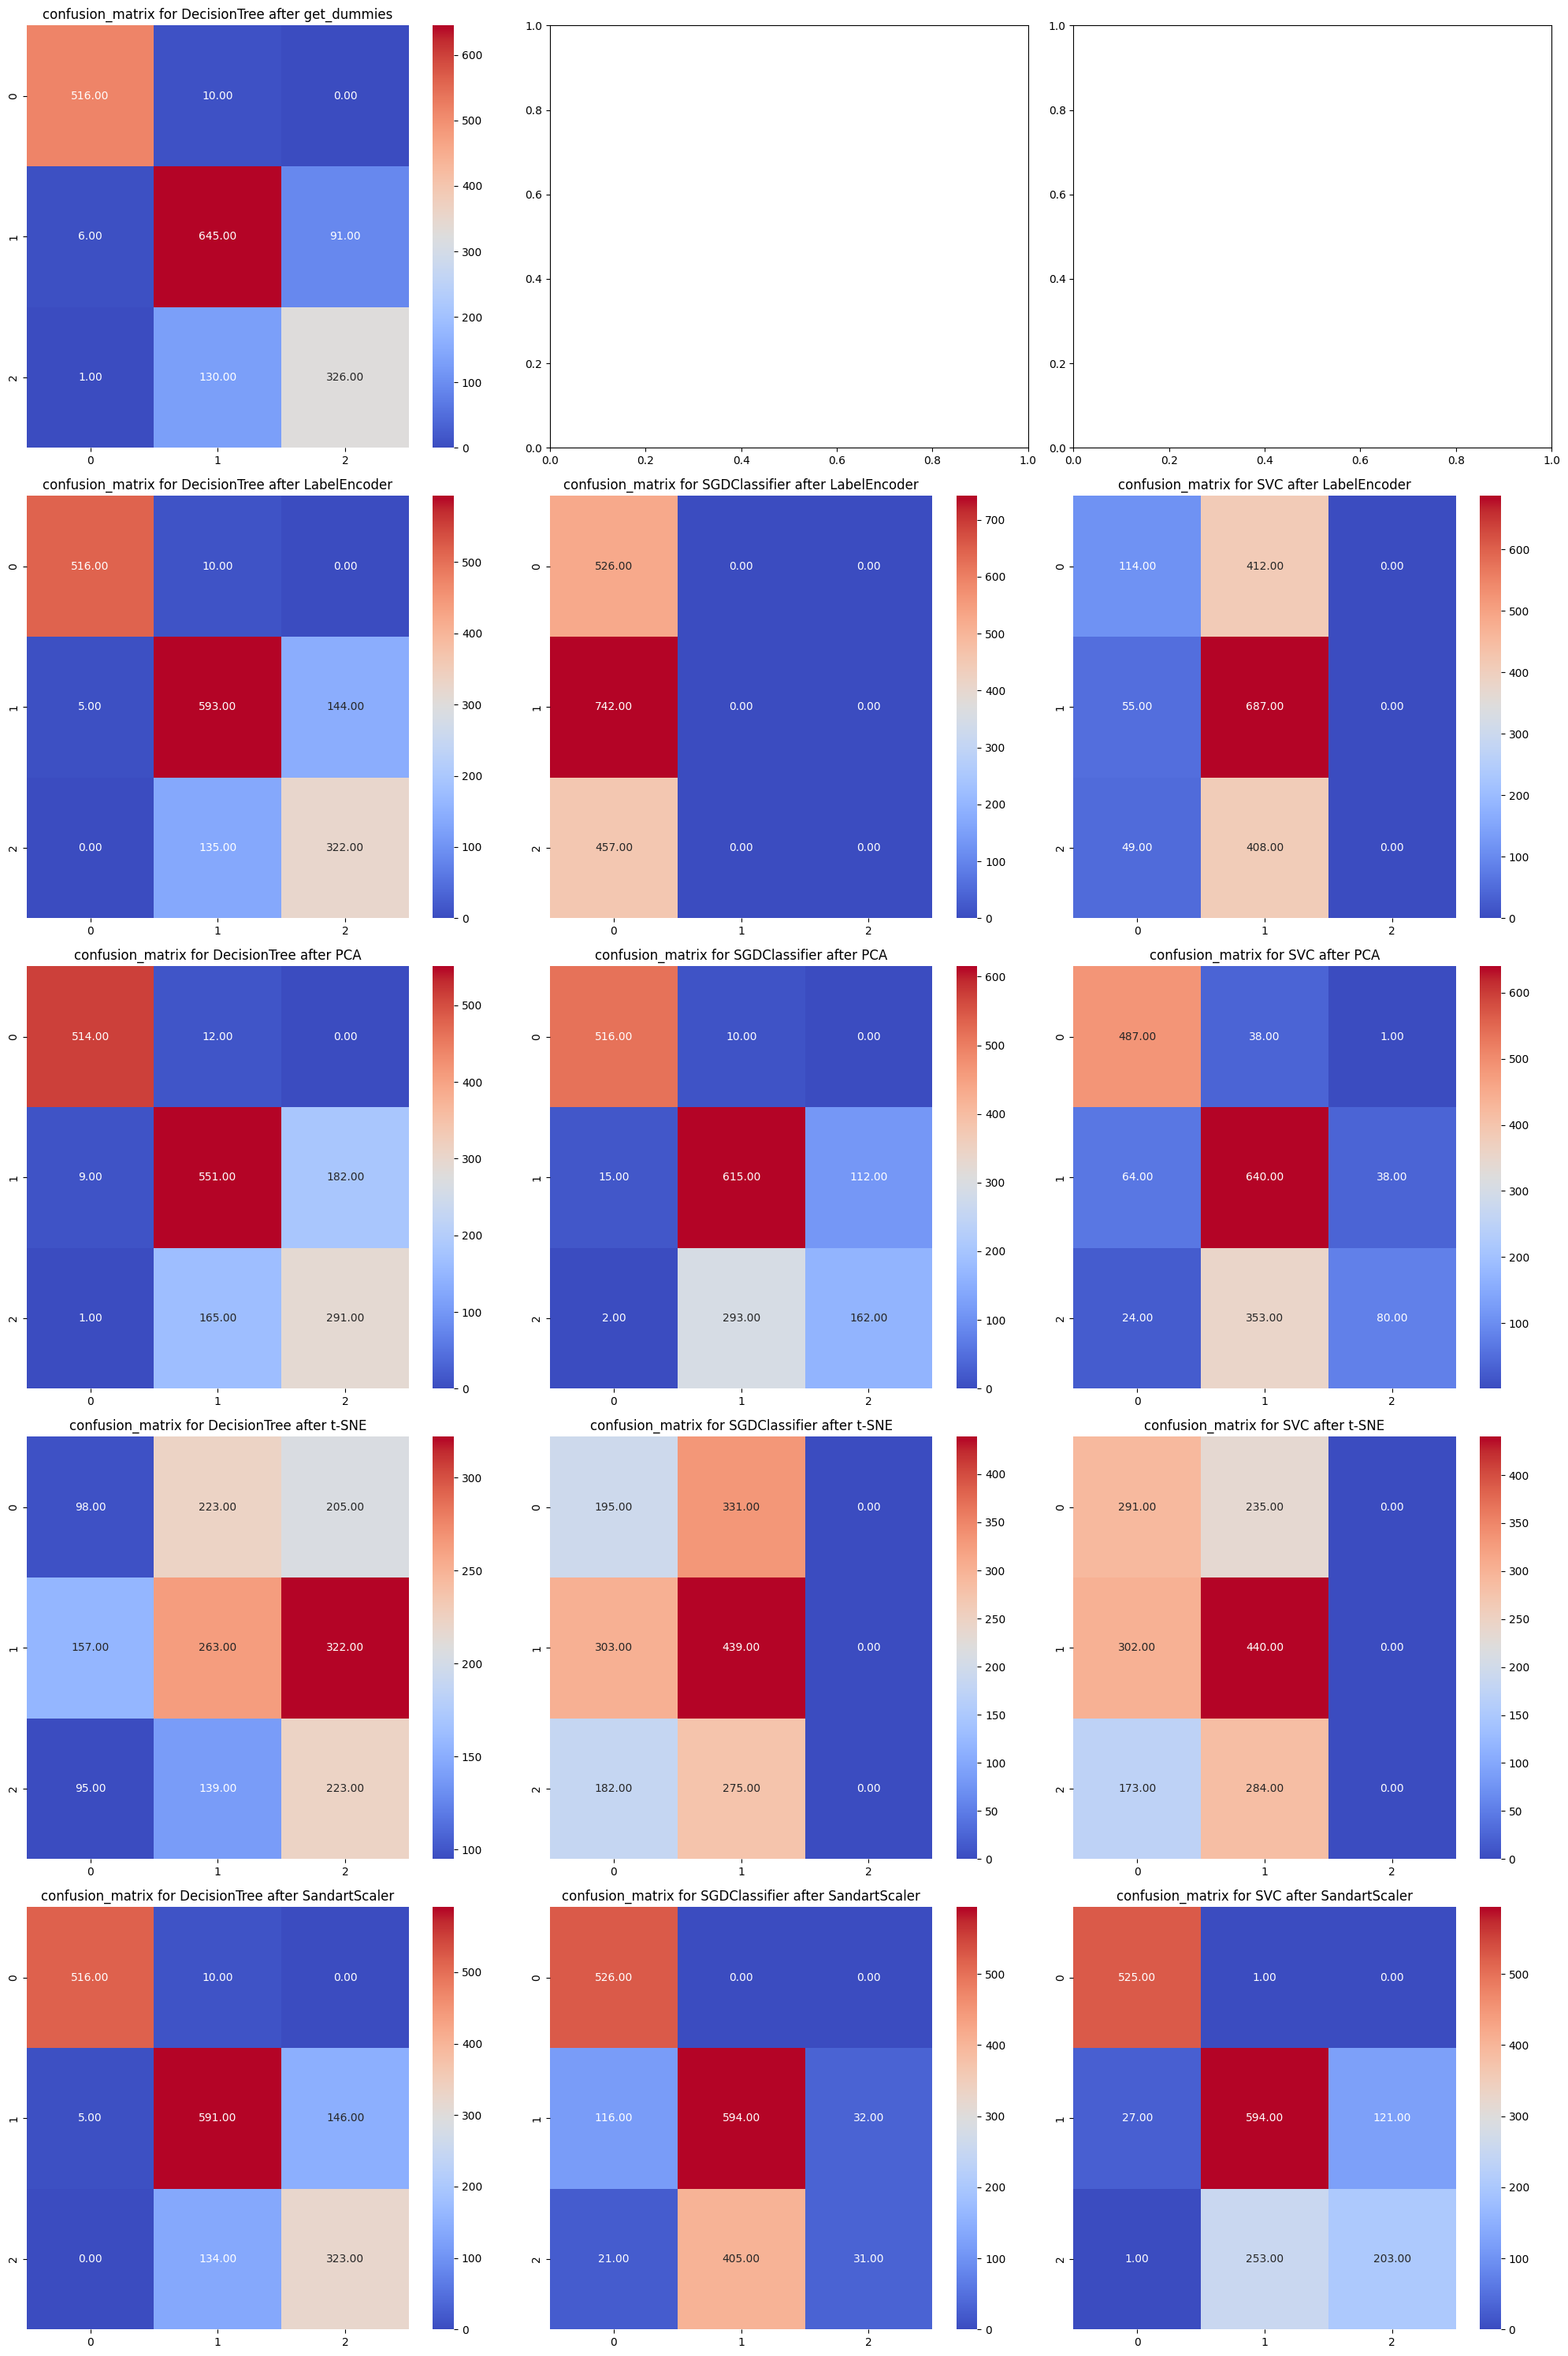

In [223]:
fig, axes = plt.subplots(5, 3, figsize=(20, 30))

sns.heatmap(confusion_matrix(Y_test, y_pred_dtc_gd), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0, 0])
axes[0, 0].set_title('confusion_matrix for DecisionTree after get_dummies')

sns.heatmap(confusion_matrix(Y_test, y_pred_dtc_lbe), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1, 0])
axes[1, 0].set_title('confusion_matrix for DecisionTree after LabelEncoder')

sns.heatmap(confusion_matrix(Y_test, y_pred_sgdc_lbe), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1, 1])
axes[1, 1].set_title('confusion_matrix for SGDClassifier after LabelEncoder')

sns.heatmap(confusion_matrix(Y_test, y_pred_svc_lbe), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1, 2])
axes[1, 2].set_title('confusion_matrix for SVC after LabelEncoder')


sns.heatmap(confusion_matrix(Y_test, y_pred_dtc_pca), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[2, 0])
axes[2, 0].set_title('confusion_matrix for DecisionTree after PCA')

sns.heatmap(confusion_matrix(Y_test, y_pred_sgdc_pca), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[2, 1])
axes[2, 1].set_title('confusion_matrix for SGDClassifier after PCA')

sns.heatmap(confusion_matrix(Y_test, y_pred_svc_pca), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[2, 2])
axes[2, 2].set_title('confusion_matrix for SVC after PCA')


sns.heatmap(confusion_matrix(Y_test, y_pred_dtc_tsne), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[3, 0])
axes[3, 0].set_title('confusion_matrix for DecisionTree after t-SNE')

sns.heatmap(confusion_matrix(Y_test, y_pred_sgdc_tsne), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[3, 1])
axes[3, 1].set_title('confusion_matrix for SGDClassifier after t-SNE')

sns.heatmap(confusion_matrix(Y_test, y_pred_svc_tsne), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[3, 2])
axes[3, 2].set_title('confusion_matrix for SVC after t-SNE')



sns.heatmap(confusion_matrix(Y_test, y_pred_dtc_scal), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[4, 0])
axes[4, 0].set_title('confusion_matrix for DecisionTree after SandartScaler')

sns.heatmap(confusion_matrix(Y_test, y_pred_sgdc_scal), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[4, 1])
axes[4, 1].set_title('confusion_matrix for SGDClassifier after SandartScaler')

sns.heatmap(confusion_matrix(Y_test, y_pred_svc_scal), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[4, 2])
axes[4, 2].set_title('confusion_matrix for SVC after SandartScaler')

plt.tight_layout()
plt.show()


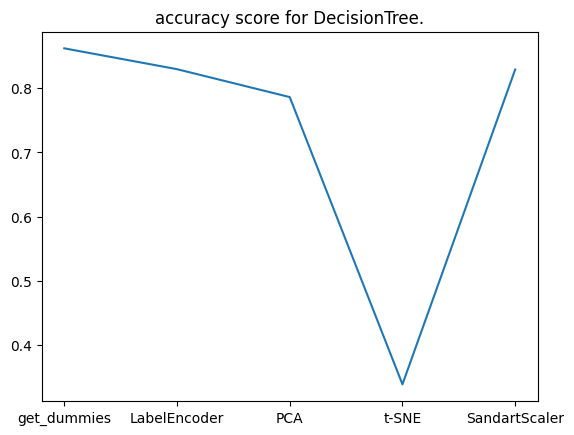

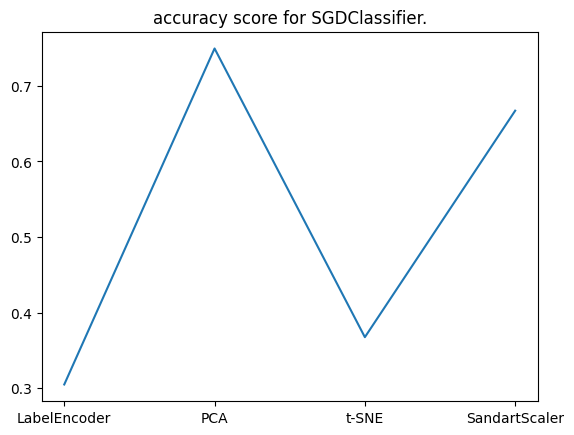

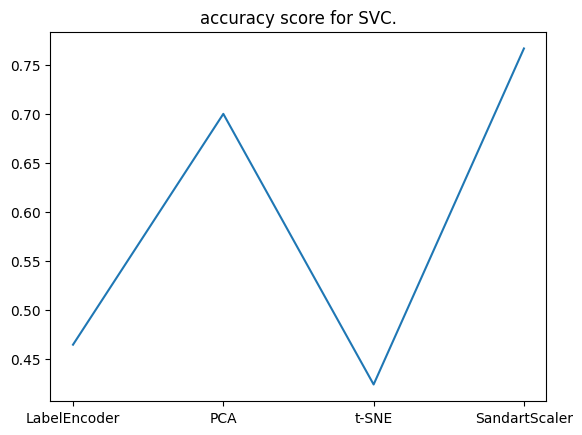

In [249]:
labels = ['get_dummies', 'LabelEncoder', 'PCA', 't-SNE', 'SandartScaler']
y_preds_dtc = [y_pred_dtc_gd, y_pred_dtc_lbe, y_pred_dtc_pca, y_pred_dtc_tsne, y_pred_dtc_scal]
accuracy_dct = list(map(lambda x: accuracy_score(Y_test, x), y_preds_dtc))

y_preds_sgdc = [ y_pred_sgdc_lbe, y_pred_sgdc_pca, y_pred_sgdc_tsne, y_pred_sgdc_scal]
accuracy_sgdc = list(map(lambda x: accuracy_score(Y_test, x), y_preds_sgdc))

y_preds_svc = [ y_pred_svc_lbe, y_pred_svc_pca, y_pred_svc_tsne, y_pred_svc_scal]
accuracy_svc = list(map(lambda x: accuracy_score(Y_test, x), y_preds_svc))


plt.plot(labels, accuracy_dct)
plt.title('accuracy score for DecisionTree.')
plt.show()


plt.plot(labels[1:], accuracy_sgdc)
plt.title('accuracy score for SGDClassifier.')
plt.show()

plt.plot(labels[1:], accuracy_svc)
plt.title('accuracy score for SVC.')
plt.show()

# Вывод

В ходе работы были соединины в один ноутбук методы уменьшения размерности данных, масштабирования данных, перебора гиперпараметров для моделей, изменения представления данных и т.д.

С решением задачи классификации на выбранном датасате лучше всего справилась модель решающего дерева, с использованием get_dummies для представления данных. Однако модели после применения PCA и LabelEncoder + StandartScaler, показали результаты чуть меньшей точности, но с большой скоростью обучения.